# Assistants

## Introduction

The Assistants API allows you to build AI assistants within your own applications. An Assistant has instructions and can leverage models, tools, and knowledge to respond to user queries. The Assistants API currently supports three types of tools: Code Interpreter, Retrieval, and Function calling.

1. Assistants can call OpenAI’s models with specific instructions to tune their personality and capabilities.
2. Assistants can access multiple tools in parallel. These can be both OpenAI-hosted tools — like Code interpreter and Knowledge retrieval — or tools you build / host (via Function calling).
3. Assistants can access persistent Threads. Threads simplify AI application development by storing message history and truncating it when the conversation gets too long for the model’s context length. You create a Thread once, and simply append Messages to it as your users reply.
4. Assistants can access Files in several formats — either as part of their creation or as part of Threads between Assistants and users. When using tools, Assistants can also create files (e.g., images, spreadsheets, etc) and cite files they reference in the Messages they create.

You can explore the capabilities of the Assistants API using the [Assistants playground](https://platform.openai.com/playground?mode=assistant) or by building a step-by-step integration outlined in this guide. At a high level, a typical integration of the Assistants API has the following flow:

1. Create an Assistant in the API by defining its custom instructions and picking a model. If helpful, enable tools like Code Interpreter, Retrieval, and Function calling.
2. Create a Thread when a user starts a conversation.
3. Add Messages to the Thread as the user ask questions.
4. Run the Assistant on the Thread to trigger responses. This automatically calls the relevant tools.

The Assistants API is in **beta**. Calls to the Assistants API require that you pass a beta HTTP header. This is handled automatically if you’re using OpenAI’s official Python or Node.js SDKs.
```htm
OpenAI-Beta: assistants=v1
```


## How Assistants Work
### Objects
![Objects](https://cdn.openai.com/API/docs/images/diagram-assistant.webp)
| OBJECT   | WHAT IT REPRESENTS |
|----------|--------------------|
| Assistant | Purpose-built AI that uses OpenAI’s models and calls tools |
| Thread   | A conversation session between an Assistant and a user. Threads store Messages and automatically handle truncation to fit content into a model’s context. |
| Message  | A message created by an Assistant or a user. Messages can include text, images, and other files. Messages stored as a list on the Thread. |
| Run      | An invocation of an Assistant on a Thread. The Assistant uses its configuration and the Thread’s Messages to perform tasks by calling models and tools. As part of a Run, the Assistant appends Messages to the Thread. |
| Run Step | A detailed list of steps the Assistant took as part of a Run. An Assistant can call tools or create Messages during its run. Examining Run Steps allows you to introspect how the Assistant is getting to its final results. |


### Step 1: Create an Assistant
An Assistant represents an entity that can be configured to respond to users’ Messages using several parameters like:

* **Instructions**: Use the instructions parameter to guide the personality of the Assistant and define it’s goals. Instructions are similar to system messages in the Chat Completions API.
* **Model**: you can specify any GPT-3.5 or GPT-4 models. The Retrieval tool requires at least `gpt-3.5-turbo-1106` (newer versions are supported) or `gpt-4-turbo-preview` models.
    * Note: Support for fine-tuned models in the Assistants API is coming soon.
* **Tools**: Use the tools parameter to give the Assistant access to up to 128 tools. You can give it access to OpenAI-hosted tools like `code_interpreter` and `retrieval`, or call a third-party tools via a `function` calling.
* **File_ids**: Use the file_ids parameter to give the tools like code_interpreter and retrieval access to files. Files are uploaded using the [File upload endpoint](https://platform.openai.com/docs/api-reference/files/create) and must have the `purpose` set to `assistants` to be used with this API.

In the following example, we're creating an Assistant that is a personal math tutor, with the Code Interpreter tool enabled.


In [1]:
# The following part is just for seeing the output in a formatted way.
def to_dict(object): 
    if type(object) == list:
         for i, item in enumerate(object):
            object[i] = to_dict(item)
    if type(object) == dict:
        for key, value in object.items():
            object[key] = to_dict(value)
    if hasattr(object, "__dict__"): return to_dict(object.__dict__)
    return object

def print_object(object):
    import json
    print(json.dumps(to_dict(object), indent=4))

In [2]:
# In this example, we're creating an Assistant that is a personal math tutor, with the Code Interpreter tool enabled.
from openai import OpenAI
client = OpenAI()

assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="You are a personal math tutor. Write and run code to answer math questions.",
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-turbo-preview"
)

### Step 2: Create a Thread
A Thread represents a conversation. We recommend [creating one Thread](https://platform.openai.com/docs/api-reference/threads/createThread) per user as soon as the user initiates the conversation. Pass any user-specific context and files in this thread by [creating Messages](https://platform.openai.com/docs/api-reference/messages/createMessage).

Threads don’t have a size limit. You can add as many Messages as you want to a Thread. The Assistant will ensure that requests to the model fit within the maximum context window, using relevant optimization techniques such as truncation which we have tested extensively with ChatGPT. When you use the Assistants API, you delegate control over how many input tokens are passed to the model for any given Run, this means you have less control over the cost of running your Assistant in some cases but do not have to deal with the complexity of managing the context window yourself.

Organizations that have enabled the [Threads page](https://platform.openai.com/threads) can view Threads created through the Assistants API and Assistants playground. Threads page permissions can be managed in [Organization settings](https://platform.openai.com/account/organization).

In [3]:
thread = client.beta.threads.create()

### Step 3: Add a Message to a Thread
A Message contains text, and optionally any files that you allow the user to upload. Messages need to be added to a specific Thread. Adding images via message objects like in Chat Completions using GPT-4 with Vision is not supported today, but we plan to add support for them in the coming months. You can still upload images and have them processes via retrieval.

In [4]:
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="I need to solve the equation `3x + 11 = 14`. Can you help me?"
)

# Now if you list the Messages in a Thread, you will see that this message has been appended.
thread_messages = client.beta.threads.messages.list(thread.id)
print_object(thread_messages.data)

[
    {
        "id": "msg_LSe4ZhGdwd5aXwKilhAjDef2",
        "assistant_id": null,
        "content": [
            {
                "text": {
                    "annotations": [],
                    "value": "I need to solve the equation `3x + 11 = 14`. Can you help me?"
                },
                "type": "text"
            }
        ],
        "created_at": 1707206041,
        "file_ids": [],
        "metadata": {},
        "object": "thread.message",
        "role": "user",
        "run_id": null,
        "thread_id": "thread_XPK509FQmEiUVP41k0ADGgN1"
    }
]


### Step 4: Run the Assistant
For the Assistant to respond to the user message, you need to create a Run. This makes the Assistant read the Thread and decide whether to call tools (if they are enabled) or simply use the model to best answer the query. As the run progresses, the assistant appends Messages to the thread with the `role="assistant"`. The Assistant will also automatically decide what previous Messages to include in the context window for the model. This has both an impact on pricing as well as model performance. The current approach has been optimized based on what we learned building ChatGPT and will likely evolve over time.

You can optionally pass new instructions to the Assistant while creating the Run but note that these instructions override the default instructions of the Assistant.

By default, a Run will use the model and tools configuration specified in Assistant object, but you can override most of these when creating the Run for added flexibility.

> ***Note***: file_ids associated with the Assistant cannot be overridden during Run creation. You must use the [modify Assistant](https://platform.openai.com/docs/api-reference/assistants/modifyAssistant) endpoint to do this.

In [5]:
# Trigger the run
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="Please address the user as Jane Doe. The user has a premium account."
)

### Step5: Check the Run Status
Run objects can have multiple statuses.

![Run lifecycle](https://cdn.openai.com/API/docs/images/diagram-1.png)

| STATUS          | DEFINITION |
|-----------------|------------|
| queued          | When Runs are first created or when you complete the required_action, they are moved to a queued status. They should almost immediately move to in_progress. |
| in_progress     | While in_progress, the Assistant uses the model and tools to perform steps. You can view progress being made by the Run by examining the Run Steps. |
| completed       | The Run successfully completed! You can now view all Messages the Assistant added to the Thread, and all the steps the Run took. You can also continue the conversation by adding more user Messages to the Thread and creating another Run. |
| requires_action | When using the Function calling tool, the Run will move to a required_action state once the model determines the names and arguments of the functions to be called. You must then run those functions and submit the outputs before the run proceeds. If the outputs are not provided before the expires_at timestamp passes (roughly 10 mins past creation), the run will move to an expired status. |
| expired         | This happens when the function calling outputs were not submitted before expires_at and the run expires. Additionally, if the runs take too long to execute and go beyond the time stated in expires_at, our systems will expire the run. |
| cancelling      | You can attempt to cancel an in_progress run using the Cancel Run endpoint. Once the attempt to cancel succeeds, status of the Run moves to cancelled. Cancellation is attempted but not guaranteed. |
| cancelled       | Run was successfully cancelled. |
| failed          | You can view the reason for the failure by looking at the last_error object in the Run. The timestamp for the failure will be recorded under failed_at. |

When a Run is in_progress and not in a terminal state, the Thread is locked. This means that:
* New Messages cannot be added to the Thread.
* New Runs cannot be created on the Thread.

In [6]:
# By default, the run goes into the queued state. You can periodically retrieve the Run to check on its status to see if it has moved to completed.
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break
print_object(run)

Run is completed
{
    "id": "run_zjNVAGjiJF0L3BvDidCfu203",
    "assistant_id": "asst_a1B4jV5omCGjezTJFpukcAw6",
    "cancelled_at": null,
    "completed_at": 1707206069,
    "created_at": 1707206050,
    "expires_at": null,
    "failed_at": null,
    "file_ids": [],
    "instructions": "Please address the user as Jane Doe. The user has a premium account.",
    "last_error": null,
    "metadata": {},
    "model": "gpt-4-turbo-preview",
    "object": "thread.run",
    "required_action": null,
    "started_at": 1707206050,
    "status": "completed",
    "thread_id": "thread_XPK509FQmEiUVP41k0ADGgN1",
    "tools": [
        {
            "type": "code_interpreter"
        }
    ],
    "usage": {
        "completion_tokens": 177,
        "prompt_tokens": 661,
        "total_tokens": 838
    }
}


### Step 6: Display the Assistant's Response
Once the Run completes, you can list the Messages added to the Thread by the Assistant.

In [7]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

#For you to better understand the data structure of the messages
print_object(messages.data)

[
    {
        "id": "msg_jt5PQ3bD7wXXg0WIRte0uP9C",
        "assistant_id": "asst_a1B4jV5omCGjezTJFpukcAw6",
        "content": [
            {
                "text": {
                    "annotations": [],
                    "value": "The solution to the equation \\(3x + 11 = 14\\) is \\(x = 1\\). If you have any more questions or need further assistance, feel free to ask!"
                },
                "type": "text"
            }
        ],
        "created_at": 1707206067,
        "file_ids": [],
        "metadata": {},
        "object": "thread.message",
        "role": "assistant",
        "run_id": "run_zjNVAGjiJF0L3BvDidCfu203",
        "thread_id": "thread_XPK509FQmEiUVP41k0ADGgN1"
    },
    {
        "id": "msg_9p10DE5l40LvuAVGSAan1cjQ",
        "assistant_id": "asst_a1B4jV5omCGjezTJFpukcAw6",
        "content": [
            {
                "text": {
                    "annotations": [],
                    "value": "Sure, we can solve the equation \\(3x + 11 =

In [8]:
# Finally display the messages to the user

# messages.data list holds the last message at the index 0, so we reverse the list to see in chronological order.
for message in reversed(messages.data):
  print(f"_______Role: {message['role']}_______\n")
  # message.content is a list, but I only see 1 item in the list, anyhow used a loop.
  for i, content in enumerate(message['content']):
    print(f"{content['text']['value']}\n")

_______Role: user_______

I need to solve the equation `3x + 11 = 14`. Can you help me?

_______Role: assistant_______

Sure, we can solve the equation \(3x + 11 = 14\) together. To find the value of \(x\), we will follow these steps:

1. Subtract 11 from both sides to isolate the term with \(x\) on one side.
2. Divide by 3 to solve for \(x\).

Let's do the calculation.

_______Role: assistant_______

The solution to the equation \(3x + 11 = 14\) is \(x = 1\). If you have any more questions or need further assistance, feel free to ask!



### Run Steps
![Run steps](https://cdn.openai.com/API/docs/images/diagram-2.png)

Run step statuses have the same meaning as Run statuses.

Most of the interesting detail in the Run Step object lives in the step_details field. There can be two types of step details:
1. `message_creation`: This Run Step is created when the Assistant creates a Message on the Thread.
2. `tool_calls`: This Run Step is created when the Assistant calls a tool. Details around this are covered in the relevant sections of the Tools guide.

In [9]:
run_steps = client.beta.threads.runs.steps.list(
    thread_id=thread.id,
    run_id=run.id
)

for step in run_steps:
    print(f"{step.step_details.type}: {getattr(step.step_details, step.step_details.type)}")

message_creation: MessageCreation(message_id='msg_jt5PQ3bD7wXXg0WIRte0uP9C')
tool_calls: [CodeToolCall(id='call_qe4hURDFkM4CCvihklIryawi', code_interpreter=CodeInterpreter(input="from sympy import symbols, Eq, solve\n\n# Define the variable\nx = symbols('x')\n\n# Define the equation\nequation = Eq(3*x + 11, 14)\n\n# Solve the equation\nsolution = solve(equation, x)\nsolution", outputs=[CodeInterpreterOutputLogs(logs='[1]', type='logs')]), type='code_interpreter')]
message_creation: MessageCreation(message_id='msg_9p10DE5l40LvuAVGSAan1cjQ')


### Cleanup

You can delete your assistant and/or threads. 

In [10]:
# Delete the assistant
client.beta.assistants.delete(assistant_id=assistant.id)

# Delete the thread
client.beta.threads.delete(thread_id=thread.id)

ThreadDeleted(id='thread_XPK509FQmEiUVP41k0ADGgN1', deleted=True, object='thread.deleted')

## Tools
Give Assistants access to OpenAI-hosted tools like Code Interpreter and Knowledge Retrieval, or build your own tools using Function calling. Usage of OpenAI-hosted tools comes at an additional fee — visit [help center article](https://help.openai.com/en/articles/8550641-assistants-api) to learn more about how these tools are priced.

### Code Interpreter
Code Interpreter allows the Assistants API to write and run Python code in a sandboxed execution environment. This tool can process files with diverse data and formatting, and generate files with data and images of graphs. Code Interpreter allows your Assistant to run code iteratively to solve challenging code and math problems. When your Assistant writes code that fails to run, it can iterate on this code by attempting to run different code until the code execution succeeds.

Code Interpreter is charged at $0.03 per session. If your Assistant calls Code Interpreter simultaneously in two different threads (e.g., one thread per end-user), two Code Interpreter sessions are created. Each session is active by default for one hour, which means that you only pay for one session per if users interact with Code Interpreter in the same thread for up to one hour.

To enable it, pass the `code_interpreter` in the `tools` parameter of the Assistant object to enable Code Interpreter. The model then decides when to invoke Code Interpreter in a Run based on the nature of the user request. This behavior can be promoted by prompting in the Assistant's instructions (e.g., “write code to solve this problem”).

#### Using Files with Code Interpreter
Code Interpreter can parse data from files. This is useful when you want to provide a large volume of data to the Assistant or allow your users to upload their own files for analysis. Note that files uploaded for Code Interpreter are not indexed for retrieval. See the Knowledge Retrieval section below for more details on indexing files for retrieval.

Files that are passed at the Assistant level are accessible by all Runs with this Assistant. Files can also be passed at individual Message level. These files are only accessible in the specific Thread.

In [20]:
# Upload a file with an "assistants" purpose
file = client.files.create(
  file=open("data/AG_news_samples.csv", "rb"),
  purpose='assistants'
)

# Create an assistant with 'code_interpreter' enabled
assistant = client.beta.assistants.create(
  instructions="You are an assistant that does exploratory data analysis given a dataset as a CSV file. When asked a question about the data, write and run code to answer the question.",
  model="gpt-4-turbo-preview",
  tools=[{"type": "code_interpreter"}]
)

thread = client.beta.threads.create()

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="How many news are labeled as 'Sports'?",
    file_ids=[file.id]
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break

Run is completed


In [21]:
# Get the response
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

for message in reversed(messages.data):
  print(f"_______Role: {message.role}_______\n")
  print(f"{message.content[0].text.value}\n")

_______Role: user_______

How many news are labeled as 'Sports'?

_______Role: assistant_______

To determine how many news articles are labeled as 'Sports', I will first load the dataset you've provided, explore its structure, and then proceed to count the number of articles accordingly. Let's start by loading and inspecting the data.

_______Role: assistant_______

The dataset contains columns for the 'title', 'description', the 'label_int', and the 'label' of each news article. To count how many news articles are labeled as 'Sports', I will filter the data based on the 'label' column and then count the occurrences. Let's proceed with that.

_______Role: assistant_______

There are 491 news articles labeled as 'Sports' in the dataset.



#### Reading images and files generated by Code Interpreter
Code Interpreter in the API also outputs files, such as generating image diagrams, CSVs, and PDFs. There are two types of files that are generated:

1. Images
2. Data files (e.g. a csv file with data generated by the Assistant)

When Code Interpreter generates an image, you can look up and download this file in the file_id field of the Assistant Message response.

In [22]:
# Add a new message to the previously created thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Can you give me a plot diagram with 'label' in the x axis, and count in the y axis?"
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break

Run is completed


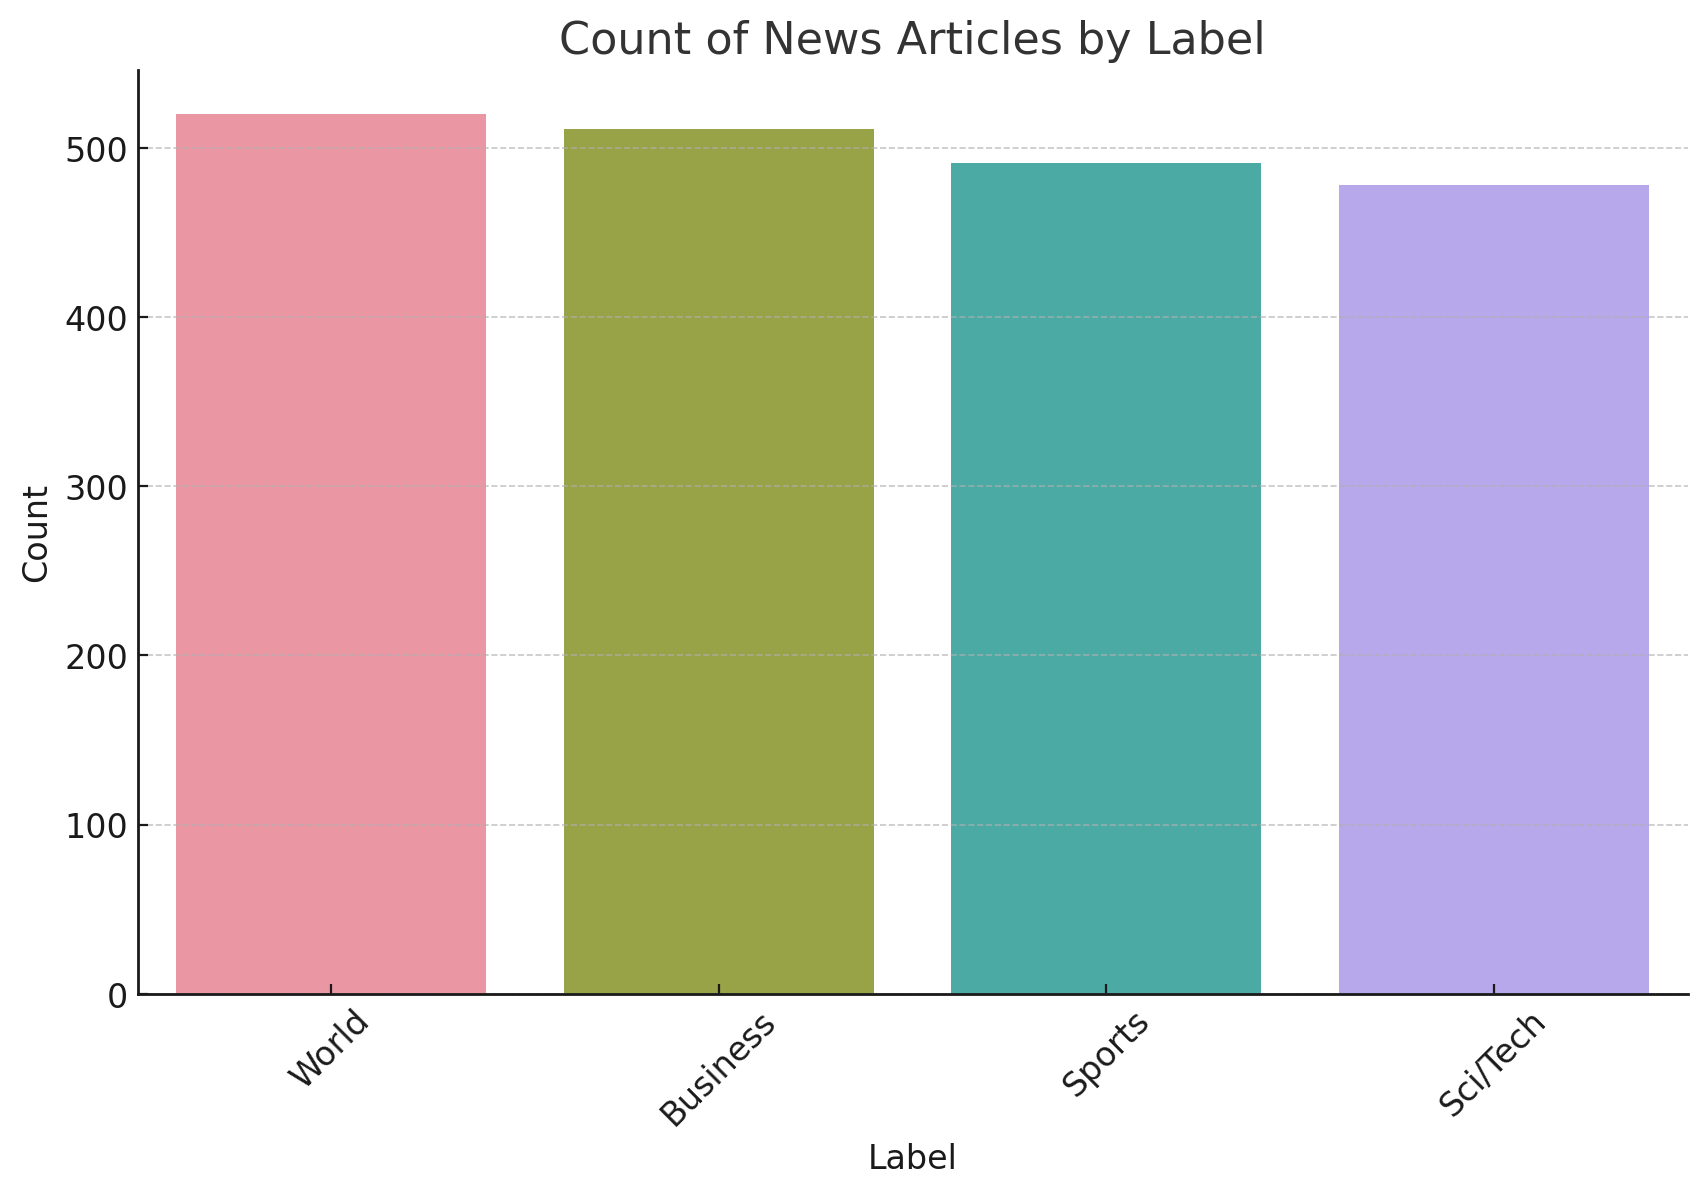

Here is a bar plot diagram showing the count of news articles by label. The 'label' is on the x-axis, and the count of news articles is on the y-axis. As you can see, each label category is represented, showing the distribution of news articles across different labels.



In [23]:
# Get the response
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

# Print only the last message (which is assistant's response)
message = messages.data[0]
for i, content in enumerate(message.content):
  if content.type == 'text':
    print(f"{content.text.value}\n")
  elif content.type == 'image_file':
    image_data = client.files.content(content.image_file.file_id)
    image_data_bytes = image_data.read()
    # Print the image
    from IPython.display import display, Image
    display(Image(data=image_data_bytes))
    # You can also save to a file
    with open("output/plot-image.png", "wb") as file:
      file.write(image_data_bytes)

#### Message annotations
Messages created by Assistants may contain annotations within the content array of the object. Annotations provide information around how you should annotate the text in the Message.

There are two types of Annotations:

1. `file_citation`: File citations are created by the `retrieval` tool and define references to a specific quote in a specific file that was uploaded and used by the Assistant to generate the response.
2. `file_path`: File path annotations are created by the `code_interpreter` tool and contain references to the files generated by the tool.

When annotations are present in the Message object, you'll see illegible model-generated substrings in the text that you should replace with the annotations. These strings may look something like 【13†source】 or sandbox:/mnt/data/file.csv. Here’s an example python code snippet that replaces these strings with information present in the annotations.

In [24]:
# Add a new message to the previously created thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Can you create a new CSV file by removing all news in 'Business' category?"
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break

Run is completed


Our response will only have `file_path` annotations. But the following code also handles `file_citation` annotations.

In [25]:
# Get the response
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

import os

# Print only the last message (which is assistant's response)
text = messages.data[0].content[0].text.value
print(f"_______Original text:_______\n{text}")

annotations = messages.data[0].content[0].text.annotations
citations = []
for i, annotation in enumerate(annotations):
    if (file_path := getattr(annotation, 'file_path', None)):
        cited_file = client.files.retrieve(file_path.file_id)
        cited_file_content = client.files.content(file_path.file_id)
        file_name = "output/" + os.path.basename(cited_file.filename)
        with open(file_name, "wb") as file:
          file.write(cited_file_content.read())
        text = text.replace(annotation.text, file_name)
    elif (file_citation := getattr(annotation, 'file_citation', None)):
        text = text.replace(annotation.text, f'[{i}]')
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f'[{i}] {file_citation.quote} from {cited_file.filename}')

# Add footnotes to the end of the message before displaying to user
if len(citations) > 0: 
  text += '\n' + '\n'.join(citations)
print(f"_______Processed text:_______\n{text}")

_______Original text:_______
I have created a new CSV file with all news articles in the 'Business' category removed. You can download the filtered file using the following link:

[Download the filtered CSV file](sandbox:/mnt/data/news_filtered_no_business.csv)
_______Processed text:_______
I have created a new CSV file with all news articles in the 'Business' category removed. You can download the filtered file using the following link:

[Download the filtered CSV file](output/news_filtered_no_business.csv)


#### Input/Output Logs of Code Interpreter

By listing the steps of a Run that called Code Interpreter, you can inspect the code input and outputs logs of Code Interpreter

In [26]:
run_steps = client.beta.threads.runs.steps.list(
    thread_id=thread.id,
    run_id=run.id
)

for step in run_steps:
    if (tool_calls := getattr(step.step_details, 'tool_calls', None)):
        print_object(tool_calls)

[
    {
        "id": "call_aFhAHm8gLYOT4C3DApoqRp6X",
        "code_interpreter": {
            "input": "# Remove all news in the 'Business' category\nfiltered_data = data[data['label'] != 'Business']\n\n# Save the filtered data to a new CSV file\nfiltered_data_path = '/mnt/data/news_filtered_no_business.csv'\nfiltered_data.to_csv(filtered_data_path, index=False)\n\nfiltered_data_path",
            "outputs": [
                {
                    "logs": "'/mnt/data/news_filtered_no_business.csv'",
                    "type": "logs"
                }
            ]
        },
        "type": "code_interpreter"
    }
]


In [ ]:
# Cleanup
assistant_files = client.beta.assistants.files.list(assistant_id=assistant.id)
for file in assistant_files:
    client.files.delete(file_id=file.id)
client.beta.assistants.delete(assistant_id=assistant.id)
client.beta.threads.delete(thread_id=thread.id)

### Knowledge Retrieval

Retrieval augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users. Once a file is uploaded and passed to the Assistant, OpenAI will automatically chunk your documents, index and store the embeddings, and implement vector search to retrieve relevant content to answer user queries.

Pass the `retrieval` in the `tools` parameter of the Assistant to enable Retrieval. The model then decides when to retrieve content based on the user Messages. The Assistants API automatically chooses between two retrieval techniques:
1. it either passes the file content in the prompt for short documents, or
2. performs a vector search for longer documents

#### Using Files with Knowledge Retrieval
Similar to Code Interpreter, files can be passed at the Assistant-level or individual Message-level. When a file is attached at the Message-level, it is only accessible within the specific Thread the Message is attached to. After having uploaded a file, you can pass the ID of this File when creating the Message. 

Note that you are not charged based on the size of the files you upload via the Files API but rather based on which files you attach to a specific Assistant or Message that get indexed.

You can attach a maximum of 20 files per Assistant, and they can be at most 512 MB each. The size of all the files uploaded by your organization should not exceed 100 GB. You can request an increase in this storage limit using the [help center](https://help.openai.com/en/). In addition to the 512 MB file size limit, each file can only contain 2,000,000 tokens. Assistant or Message creation will fail if any attached files exceed the token limit.

You can also use the `AssistantFile` object to create, delete, or view associations between Assistant and File objects. Note that deleting an AssistantFile doesn’t delete the original File object, it simply deletes the association between that File and the Assistant. To delete a File, use the File delete endpoint instead.

#### Supported files
For text/ MIME types, the encoding must be one of `utf-8`, `utf-16`, or `ascii`.

| FILE FORMAT | MIME TYPE                                                                 | CODE INTERPRETER  | RETRIEVAL  |
|-------------|---------------------------------------------------------------------------|-------------------|------------|
| .c          | text/x-c                                                                  |         ✓         |      ✓     |
| .cpp        | text/x-c++                                                                |         ✓         |      ✓     |
| .csv        | application/csv                                                           |         ✓         |      ✓     |
| .docx       | application/vnd.openxmlformats-officedocument.wordprocessingml.document   |         ✓         |      ✓     |
| .html       | text/html                                                                 |         ✓         |      ✓     |
| .java       | text/x-java                                                               |         ✓         |      ✓     |
| .json       | application/json                                                          |         ✓         |      ✓     |
| .md         | text/markdown                                                             |         ✓         |      ✓     |
| .pdf        | application/pdf                                                           |         ✓         |      ✓     |
| .php        | text/x-php                                                                |         ✓         |      ✓     |
| .pptx       | application/vnd.openxmlformats-officedocument.presentationml.presentation |         ✓         |      ✓     |
| .py         | text/x-python                                                             |         ✓         |      ✓     |
| .py         | text/x-script.python                                                      |         ✓         |      ✓     |
| .rb         | text/x-ruby                                                               |         ✓         |      ✓     |
| .tex        | text/x-tex                                                                |         ✓         |      ✓     |
| .txt        | text/plain                                                                |         ✓         |      ✓     |
| .css        | text/css                                                                  |         ✓         |            |
| .jpeg       | image/jpeg                                                                |         ✓         |            |
| .jpg        | image/jpeg                                                                |         ✓         |            |
| .js         | text/javascript                                                           |         ✓         |            |
| .gif        | image/gif                                                                 |         ✓         |            |
| .png        | image/png                                                                 |         ✓         |            |
| .tar        | application/x-tar                                                         |         ✓         |            |
| .ts         | application/typescript                                                    |         ✓         |            |
| .xlsx       | application/vnd.openxmlformats-officedocument.spreadsheetml.sheet         |         ✓         |            |
| .xml        | application/xml or "text/xml"                                             |         ✓         |            |
| .zip        | application/zip                                                           |         ✓         |            |

#### Retrieval pricing
Retrieval is priced at $0.20 per GB per assistant per day. Attaching a single file ID to multiple assistants will incur the per assistant per day charge when the retrieval tool is enabled. For example, if you attach the same 1 GB file to two different Assistants with the retrieval tool enabled (e.g., customer-facing Assistant #1 and internal employee Assistant #2), you’ll be charged twice for this storage fee (2 * $0.20 per day). This fee does not vary with the number of end users and threads retrieving knowledge from a given assistant.

In addition, files attached to messages are charged on a per-assistant basis if the messages are part of a run where the retrieval tool is enabled. For example, running an assistant with retrieval enabled on a thread with 10 messages each with 1 unique file (10 total unique files) will incur a per-GB per-day charge on all 10 files (in addition to any files attached to the assistant itself).

#### Deleting files
To remove a file from the assistant, you can detach the file from the assistant. Detaching the file from the assistant removes the file from the retrieval index and means you will no longer be charged for the storage of the indexed file.
```python
file_deletion_status = client.beta.assistants.files.delete(
  assistant_id=assistant.id,
  file_id=file.id
)
```


In [30]:
# Upload a file with an "assistants" purpose
file = client.files.create(
  file=open("data/Assistants_tools _OpenAI.pdf", "rb"),
  purpose='assistants'
)

# Create an assistant with 'retrieval' enabled and the file is added
assistant = client.beta.assistants.create(
  instructions="You are an assistant who is specialized on 'Tools that can be used with OpenAI Assistants'. You will retrieve the knowledge from the attached file to answer the questions. For the questions that are not related with your specilty, kindly reject to answer.",
  model="gpt-4-turbo-preview",
  tools=[{"type": "retrieval"}],
  file_ids=[file.id]
)

thread = client.beta.threads.create()

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="What are the different type of tools that I can use with Assistants API?"
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break

Run is completed


In [31]:
# Ask an irrelevant question, see if it rejects. Normally ChatGPT with GPT-4 is responding this question.
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="What are the alternative solutions that I can use instead of Redis?"
)

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

# Wait for Run to be completed
import time

while True:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    if run.status in ['queued', 'in_progress', 'requires_action', 'cancelling']:
        continue
    if run.status in ["completed", "expired", "failed", "cancelled"]:
        print(f"Run is {run.status}")
        break
    break

Run is completed


In [32]:
# Get the response
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

for message in reversed(messages.data):
  print(f"_______Role: {message.role}_______\n")
  print(f"{message.content[0].text.value}\n")

_______Role: user_______

What are the different type of tools that I can use with Assistants API?

_______Role: assistant_______

One of the types of tools you can use with the Assistants API includes **Function Calling**. This feature allows you to define functions within the Assistant, which the Assistant can then intelligently identify and recommend to be called along with their arguments during runtime. If a function gets invoked during a session, the execution pauses, allowing you to supply the results of the function call back, after which the assistant's execution continues. Here is an overview of how it works:

- **Defining Functions:** You define your functions when creating an assistant. These functions can perform various tasks, such as fetching the current weather or getting the nickname of a city, by specifying their names, descriptions, and required parameters.
- **Reading Function Calls:** When a run triggers a function, it enters a pending status until the required act

In [33]:
# Cleanup
assistant_files = client.beta.assistants.files.list(assistant_id=assistant.id)
for file in assistant_files:
    client.files.delete(file_id=file.id)

client.beta.assistants.delete(assistant_id=assistant.id)
client.beta.threads.delete(thread_id=thread.id)

ThreadDeleted(id='thread_QOLHOWGF1XzKXT7MDne9sa0H', deleted=True, object='thread.deleted')